In [ ]:
a = []
while True:
	a.append("random")

In [1]:
!pip install gym[atari]

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [3]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (47.3.1)


In [4]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display as ipythondisplay

from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import math
import random
import glob
import io
import base64
from IPython.display import HTML
from collections import deque

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras import initializers
from keras.optimizers import Adam, RMSprop
from keras import backend as K

Using TensorFlow backend.


#TESTING ENVIRONMENT

In [5]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [6]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [7]:
#TESTING ENVIRONMENT

ENV_NAME = 'CartPole-v1'
env = wrap_env(gym.make(ENV_NAME))
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

def test_Agent(env):
  env.reset()
  reward1 = 0
  done = False
  steps = 0
  while not done:
      env.render()
      action = env.action_space.sample()      
      observation, reward, done, _ = env.step(action) 
      reward1 += reward
      steps += 1
  env.close()
  show_video()
  return reward1, steps


r, s = test_Agent(env)
print (f'Reward before training: {r}')
print (f'Max_steps: {s}')

Observation space: Box(4,)
Action space: Discrete(2)


Reward before training: 9.0
Max_steps: 9


#PART 1: Implementing and applying DQN (with experience replay and target network)

In [8]:
UPDATE_MIN = 10
def model(input_shape, num_classes):
  weights = initializers.RandomNormal(stddev=0.01)
  model = Sequential()
  model.add(Dense(256, kernel_initializer=weights, activation='relu', input_shape=input_shape))
  model.add(Dense(128, kernel_initializer=weights, activation='relu'))
  model.add(Dense(64, kernel_initializer=weights,activation='relu'))
  model.add(Dense(32, kernel_initializer=weights,activation='relu'))  
  model.add(Dense(num_classes,  kernel_initializer=weights, activation='linear'))

  model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['accuracy'])
  model.summary()
  return model

def init_zeros(dim):
  a = np.zeros((BATCH_SIZE, dim))
  b = np.zeros((BATCH_SIZE, dim))
  return a, b

class Dqn_Agent:
  def __init__(self, env, gamma):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space
    self.gamma = gamma
    self.replay_memory = deque(maxlen=N)
    self.count = 0
    self.main_network = model((self.observation_space.shape[0], ), self.action_space.n)
    self.target_network = model((self.observation_space.shape[0], ), self.action_space.n)
    self.init_weights()
  
  def init_weights(self):
    self.target_network.set_weights(self.main_network.get_weights())
  
  def replay(self, done):
    if len(self.replay_memory) < MIN_REPLAY_SIZE:
      return
    minibatch_transitions = random.sample(self.replay_memory, BATCH_SIZE)
    states, next_states = init_zeros(self.observation_space.shape[0])
    for index, transition in enumerate(minibatch_transitions):
      states[index] = transition[0]
      next_states[index] = transition[3]

    #print (states.shape, next_states.shape)

    states_qs = self.main_network.predict(states)
    next_states_qs = self.target_network.predict(next_states)

    self.count = self.count + 1 if done else self.count
    if self.count >= UPDATE_MIN:
      self.count = 0
      #print('Here')
      self.init_weights()
    
    for index, transition in enumerate(minibatch_transitions):
      #state, action, reward, new_state, done
      states_qs[index][transition[1]] = transition[2] if transition[4] else (transition[2] + self.gamma * (np.max(next_states_qs[index])))
    
    #print (states.shape, states_qs.shape)
     
    self.main_network.fit(states, states_qs, batch_size=BATCH_SIZE, verbose=0, shuffle=False)

##Training and testing DQN on our environment

In [9]:
def train_agent(env, agent, epsilon):
  total_rewards, epsilons, timesteps = [], [], []
  dim = env.observation_space.shape[0]
  eps1 = epsilon * DECAY
  for episode in range(EPISODES):
    state = env.reset()
    done, current_rewards, timestep = False, 0, 0
    while not done:
      state = np.reshape(state, [1, dim])
      if np.random.uniform(0, 1) < epsilon:
        action = agent.action_space.sample()
      else:
        action = np.argmax(agent.main_network.predict(state))

      next_state, reward, done, _ = env.step(action)
      next_state = np.reshape(next_state, [1, dim])
      current_rewards += reward
      timestep += 1
      if done:
        #print ('here')
        reward = -25
      agent.replay_memory.append((state, action, reward, next_state, done))
      state = next_state
      agent.replay(done)
    print(f'Episode: {episode}, Reward: {current_rewards}, Timesteps: {timestep}, Epsilon: {epsilon}')
    timesteps.append(timestep)
    total_rewards.append(current_rewards)
    tmp = np.exp(-1 * eps1 * episode)
    epsilons.append(tmp)
    epsilon = tmp    

  return agent, epsilons, total_rewards, timesteps

def test1(env, agent):
# self.load("cartpole-dqn.h5")
  state = env.reset()
  done = False
  dim = env.observation_space.shape[0]
  current_rewards = 0
  while not done:
    env.render()
    state = np.reshape(state, [1, dim])
    action = np.argmax(agent.main_network.predict(state))
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, dim])
    state = next_state.copy()
    current_rewards += 1

  print(f'Reward: {current_rewards}')
  env.close()
  show_video()

In [10]:
epsilon, DECAY, EPS_MIN = 1, 0.01, 0.001
GAMMA = 0.9
BATCH_SIZE = 128
MIN_REPLAY_SIZE, N = 500, 2000
EPISODES = 800

In [11]:
env1 = gym.make('CartPole-v1')
agent = Dqn_Agent(env1, GAMMA)

#Train
agent, epsilons, total_rewards, timesteps = train_agent(env1, agent, epsilon)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               1280      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 44,578
Trainable params: 44,578
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                

In [12]:
#Test
env2 = wrap_env(gym.make('CartPole-v1'))
test1(env2, agent)

Reward: 240


##Plot

In [41]:
def plotEpsilon(epsilons):
  plt.plot(epsilons)
  plt.xlabel('Episode')
  plt.ylabel('Epsilon')
  plt.show()

def plotRewards(total_rewards):
  plt.plot(total_rewards)
  plt.xlabel('Episode')
  plt.ylabel('Total Reward (per episode)')
  plt.show()

def plot1(epsilons, total_rewards):
  plt.plot(epsilons, total_rewards)
  plt.xlabel('Epsilon')
  plt.ylabel('Total Reward (per episode)')
  plt.show()

def plotAverageReward(total_rewards):
  plt.xlabel('Episode')
  plt.ylabel('Total Reward (Average reward in 10 episodes)')
  plt.plot([np.mean(total_rewards[tr:tr+10]) for tr in range(10, len(total_rewards))])
  plt.show()

def slidingAverage(timesteps):
  count = 0
  total = 0
  solved, step = False, 0
  for i in range(len(timesteps)):
    if i >= 100:
      if ((total / 100)  >= 195):
        solved = True
        step = i
        return solved, step
      total -= timesteps[i - 100]
    total += timesteps[i]
  return solved, step

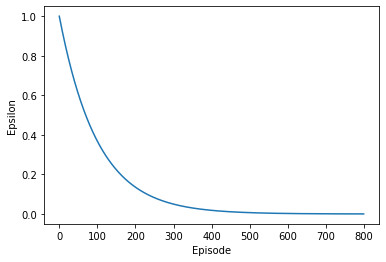

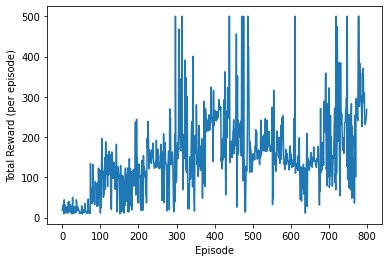

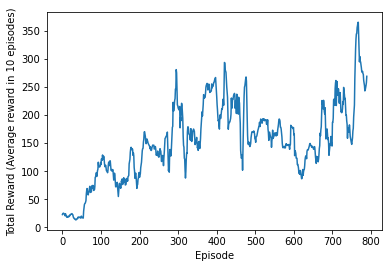

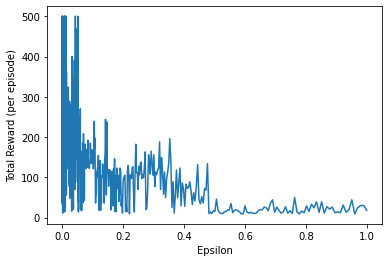

(True, 406)


In [42]:
plotEpsilon(epsilons)
plotRewards(total_rewards)
plotAverageReward(total_rewards)
plot1(epsilons, total_rewards)
print (slidingAverage(timesteps))
#plotTimesteps(timesteps)

#PART 2: Improving DQN (using Double DQN)

In [37]:
TAU = 0.75

In [38]:
class Double_DQN_Agent:
  def __init__(self, env, gamma):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space
    self.gamma = gamma
    self.replay_memory = deque(maxlen=2000)
    self.main_network = model((self.observation_space.shape[0], ), self.action_space.n)
    self.target_network = model((self.observation_space.shape[0], ), self.action_space.n)
    #self.init_weights()
  
  def init_weights(self):
    self.target_network.set_weights(self.main_network.get_weights())
  
  def update_weights(self):
    #TAU * (THETA) + (1 - TAU)*(THETA`)
    theta = np.array(self.main_network.get_weights())
    theta_prime = np.array(self.target_network.get_weights())
    self.target_network.set_weights(TAU * theta + (1 - TAU) * theta_prime)
    #print('Here')

  def replay(self, done):
    if len(self.replay_memory) < MIN_REPLAY_SIZE:
      return
    minibatch_transitions = random.sample(self.replay_memory, BATCH_SIZE)
    states, next_states = init_zeros(self.observation_space.shape[0])
    for index, transition in enumerate(minibatch_transitions):
      states[index] = transition[0]
      next_states[index] = transition[3]
      
    #print (states.shape, next_states.shape)

    states_qs = self.main_network.predict(states)
    next_states_qs_main = self.main_network.predict(next_states)
    next_states_qs_future = self.target_network.predict(next_states)
    
    for index, transition in enumerate(minibatch_transitions):
      #state, action, reward, new_state, done
      states_qs[index][transition[1]] = transition[2] if transition[4] else transition[2] + self.gamma * (next_states_qs_future[index][np.argmax(next_states_qs_main[index])])
    
    #print (states.shape, states_qs.shape)
     
    self.main_network.fit(states, states_qs, batch_size=BATCH_SIZE, verbose=0)

##Training anf testing our double dqn agent

In [39]:
def train_ddqn_agent(env, agent, epsilon):
  total_rewards, epsilons, timesteps = [], [], []
  dim = env.observation_space.shape[0]
  eps1 = epsilon * DECAY
  for episode in range(EPISODES1):
    state = env.reset()
    done, current_rewards, timestep = False, 0, 0
    while not done:
      state = np.reshape(state, [1, dim])
      if np.random.uniform(0, 1) < epsilon:
        action = agent.action_space.sample()
      else:
        action = np.argmax(agent.main_network.predict(state))

      next_state, reward, done, _ = env.step(action)
      next_state = np.reshape(next_state, [1, dim])
      current_rewards += reward
      timestep += 1
      if done:
        #print ('here')
        reward = -25
      agent.replay_memory.append((state, action, reward, next_state, done))
      state = next_state
      agent.replay(done)
    agent.update_weights()
    print(f'Episode: {episode}, Reward: {current_rewards}, Timesteps: {timestep}, Epsilon: {epsilon}')
    timesteps.append(timestep)
    total_rewards.append(current_rewards)
    tmp = np.exp(-1 * eps1 * episode)
    epsilons.append(tmp)
    epsilon = tmp    

  return agent, epsilons, total_rewards, timesteps

In [40]:
env1 = gym.make('CartPole-v1')
agent1 = Double_DQN_Agent(env1,GAMMA)
EPISODES1 = 1500
#Train

agent1, epsilons1, total_rewards1, timesteps1 =  train_ddqn_agent(env1, agent1, epsilon)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_52 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_53 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_54 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_55 (Dense)             (None, 2)                 66        
Total params: 44,578
Trainable params: 44,578
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_12"
_________________________________________________________________
Layer (type)              

In [19]:
#Test
env2 = wrap_env(env1)
test1(env2, agent1)

Reward: 121


##Plot

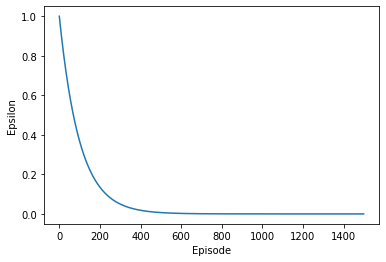

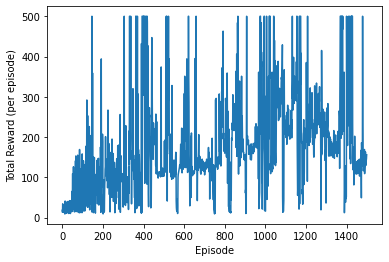

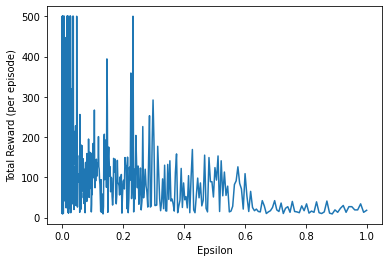

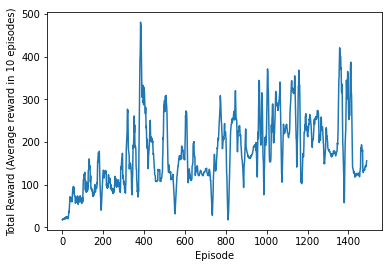

(True, 412)


In [43]:
plotEpsilon(epsilons1)
plotRewards(total_rewards1)
plot1(epsilons1, total_rewards1)
plotAverageReward(total_rewards1)
print (slidingAverage(timesteps1))